# Importing Necessary Libraries

In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MaxAbsScaler, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback

# Loading Data & Pre-Processing 

In [51]:
# Load the data
df = pd.read_csv('./vgsales.csv')
df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [52]:
# Get some information about dataset
df.info()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


,count,mean,std,min,25%,50%,75%,max
Rank,16598.0,8300.605254,4791.853933,1.00,4151.25,8300.50,12449.75,16600.00
Year,16327.0,2006.406443,5.828981,1980.00,2003.00,2007.00,2010.00,2020.00
NA_Sales,16598.0,0.264667,0.816683,0.00,0.00,0.08,0.24,41.49
EU_Sales,16598.0,0.146652,0.505351,0.00,0.00,0.02,0.11,29.02
JP_Sales,16598.0,0.077782,0.309291,0.00,0.00,0.00,0.04,10.22
Other_Sales,16598.0,0.048063,0.188588,0.00,0.00,0.01,0.04,10.57
Global_Sales,16598.0,0.537441,1.555028,0.01,0.06,0.17,0.47,82.74


In [53]:
df.isnull().sum()

Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

In [54]:
# Handle missing values
df.dropna(inplace=True)

C:\Users\nisha\AppData\Local\Temp\ipykernel_48840\1705886092.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')


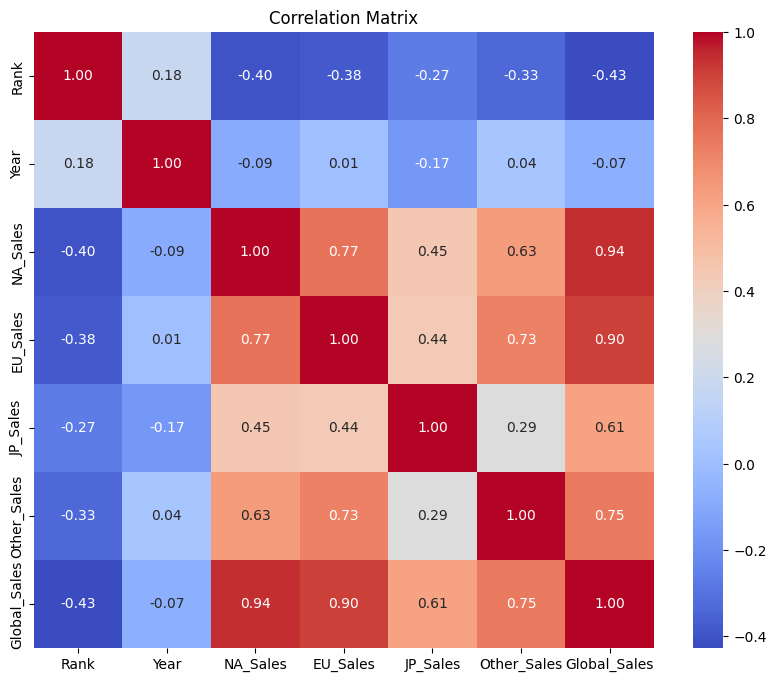

In [40]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Filter & Remove any outliers
def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    data_filtered = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return data_filtered

df_filtered = remove_outliers(df, 'Global_Sales')

In [7]:
# Feature engineering: convert categorical data
categorical_features = ['Platform', 'Genre']
one_hot = OneHotEncoder(handle_unknown='ignore')
transformer = ColumnTransformer([("one_hot", one_hot, categorical_features)], remainder="passthrough")

# Prepare features and labels
X = df.drop(['Rank', 'Name', 'Global_Sales', 'Publisher', 'Year'], axis=1)
y = df_filtered['Global_Sales']

# Data normalization
scaler = MaxAbsScaler()

# Develop the models

## Group 1: Linear Regression

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [9]:
# Create a modeling pipeline
linear_pipe = Pipeline([
    ('transformer', transformer),
    ('scaler', scaler),
    ('model', LinearRegression())
])

In [10]:
# Fit models
linear_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Platform', 'Genre'])])),
                ('scaler', MaxAbsScaler()), ('model', LinearRegression())])

## Group 2: FNN Model

In [ ]:
# Define a callback to compute testing MSE after each epoch
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.test_loss = []

    def on_epoch_end(self, epoch, logs=None):
        x, y = self.test_data
        loss = self.model.evaluate(x, y, verbose=0)
        self.test_loss.append(loss)
        print(f'Testing loss for epoch {epoch + 1}: {loss}')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer([("one_hot", one_hot, categorical_features)], remainder="passthrough")

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Preprocess the data
X_preprocessed = pipeline.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=46)

In [ ]:
# Model definition
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1) 
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Instantiate the TestCallback with test dataS
test_callback = TestCallback((X_test, y_test))

# Train the model with callback to evaluate test loss
history = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_test, y_test), verbose=1)

## Group 3: Gradient Boosting & Random Forest

### Gradient Boosting

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [11]:
gradient_boosting_pipe = Pipeline([
    ('transformer', transformer),
    ('scaler', scaler),
    ('model', GradientBoostingRegressor(n_estimators=100, random_state=42))
])

In [12]:
gradient_boosting_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Platform', 'Genre'])])),
                ('scaler', MaxAbsScaler()),
                ('model', GradientBoostingRegressor(random_state=42))])

### Random Forest

In [13]:
### Random Forest
random_forest_pipe = Pipeline([
    ('transformer', transformer),
    ('scaler', scaler),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [14]:
random_forest_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Platform', 'Genre'])])),
                ('scaler', MaxAbsScaler()),
                ('model', RandomForestRegressor(random_state=42))])

# Evaluation

In [15]:
#Group 1 & 3
linear_predictions = linear_pipe.predict(X_test)
forest_predictions = random_forest_pipe.predict(X_test)
boosting_predictions = gradient_boosting_pipe.predict(X_test)

print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, linear_predictions)))
print("Linear Regression R^2:", r2_score(y_test, linear_predictions))

print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, forest_predictions)))
print("Random Forest R^2:", r2_score(y_test, forest_predictions))

print("Gradient Boosting RMSE:", np.sqrt(mean_squared_error(y_test, boosting_predictions)))
print("Gradient Boosting R^2:", r2_score(y_test, boosting_predictions))

Linear Regression RMSE: 0.005314912205317581
Linear Regression R^2: 0.9999922055729307
Random Forest RMSE: 0.7851768822635815
Random Forest R^2: 0.8298911077635349
Gradient Boosting RMSE: 0.7015368988111066
Gradient Boosting R^2: 0.8642021028128034


In [ ]:
# Group 2
test_loss = model.evaluate(X_test, y_test)

# Predictions to calculate R-Squared
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f'RMSE for training data:', np.sqrt(model.evaluate(X_train, y_train, verbose=0)))
print(f'R-squared for training data:', r2_score(y_train, y_train_pred))

print(f'RMSE for testing data:', np.sqrt(model.evaluate(X_test, y_test, verbose=0)))
print(f'R-squared for testing data:', r2_score(y_test, y_test_pred))

In [16]:
# Group 1 & 3
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Adjust the cross-validation to use the pipeline
cv_scores_linear = cross_val_score(linear_pipe, X, y, cv=kf, scoring='neg_mean_squared_error')
cv_scores_forest = cross_val_score(random_forest_pipe, X, y, cv=kf, scoring='neg_mean_squared_error')
cv_scores_boosting = cross_val_score(gradient_boosting_pipe, X, y, cv=kf, scoring='neg_mean_squared_error')

# Print the cross-validation RMSE scores
print("Linear Regression CV RMSE:", np.sqrt(-np.mean(cv_scores_linear)))
print("Random Forest CV RMSE:", np.sqrt(-np.mean(cv_scores_forest)))
print("Gradient Boosting CV RMSE:", np.sqrt(-np.mean(cv_scores_boosting)))

Linear Regression CV RMSE: 0.005225279741387912
Random Forest CV RMSE: 0.4450442640034359
Gradient Boosting CV RMSE: 0.39207841173592134


In [ ]:
# Group 2
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1

rmse_scores = []
r_squared_scores = []

for train_index, test_index in kf.split(X_preprocessed):
    X_train, X_test = X_preprocessed[train_index], X_preprocessed[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Define the model architecture
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Create callback
    test_callback = TestCallback((X_test, y_test))

    # Train the model with callback to evaluate test loss
    history = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_test, y_test), callbacks=[test_callback], verbose=1)

    # Evaluate the model
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    test_rmse = np.sqrt(test_loss)
    y_test_pred = model.predict(X_test)
    test_r_squared = r2_score(y_test, y_test_pred)

    rmse_scores.append(test_rmse)
    r_squared_scores.append(test_r_squared)

    # Print results for the current fold
    print(f"Fold {fold_no}: RMSE = {test_rmse}, R-squared = {test_r_squared}")
    fold_no += 1

# Calculate average RMSE and R-squared across all folds
print(f"Average RMSE: {np.mean(rmse_scores)}")
print(f"Average R-squared: {np.mean(r_squared_scores)}")

## Visualization

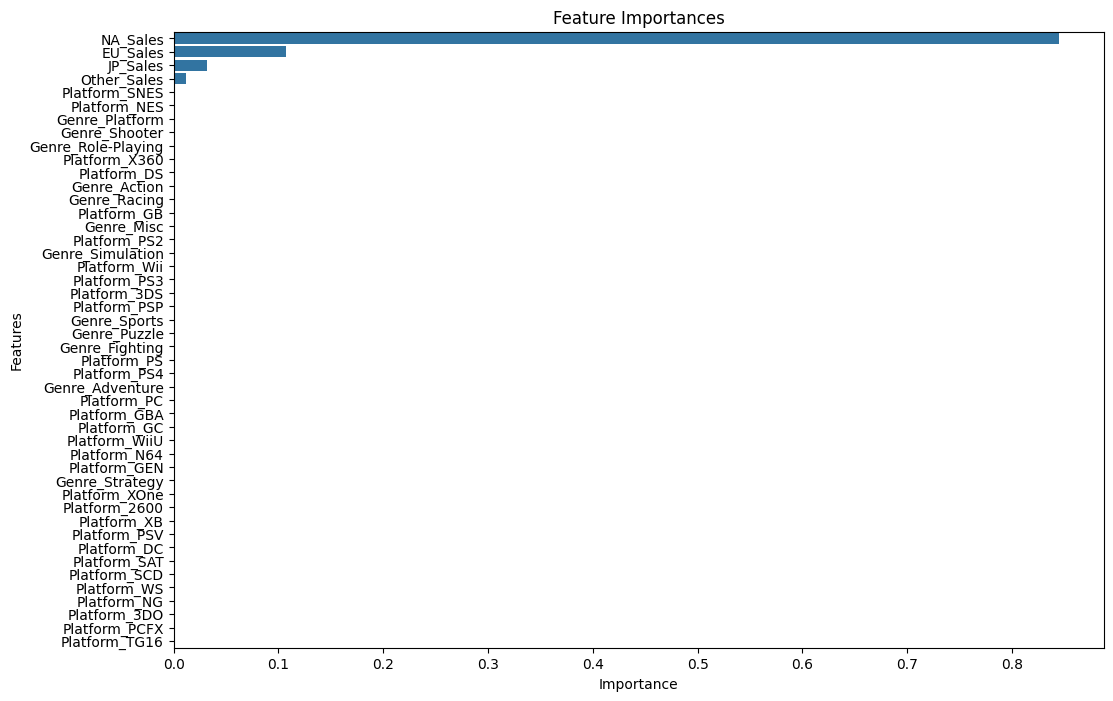

In [17]:
# Feature Importance from Random Forest
feature_importances = random_forest_pipe.named_steps['model'].feature_importances_
features = random_forest_pipe.named_steps['transformer'].transformers_[0][1].get_feature_names_out().tolist() + ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
feature_imp_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances}).sort_values('Importance', ascending=False)

# Graph for feature importance
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_imp_df, x='Importance', y='Feature')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [ ]:
# Actual Vs. Predicted
plt.figure(figsize=(12, 6))
plt.scatter(y_test, linear_predictions, alpha=0.8, label='Linear Regression', color='blue', marker='o')
plt.scatter(y_test, forest_predictions, alpha=0.5, label='Random Forest', color='red', marker='x')
plt.scatter(y_test, boosting_predictions, alpha=0.5, label='Gradient Boosting', color='yellow', marker='^')
plt.plot(y_test, y_test, 'g--', label='Perfect Prediction')
plt.xlabel('Actual Global Sales')
plt.ylabel('Predicted Global Sales')
plt.title('Actual vs Predicted Global Sales')
plt.legend()
plt.grid(True)
plt.show()

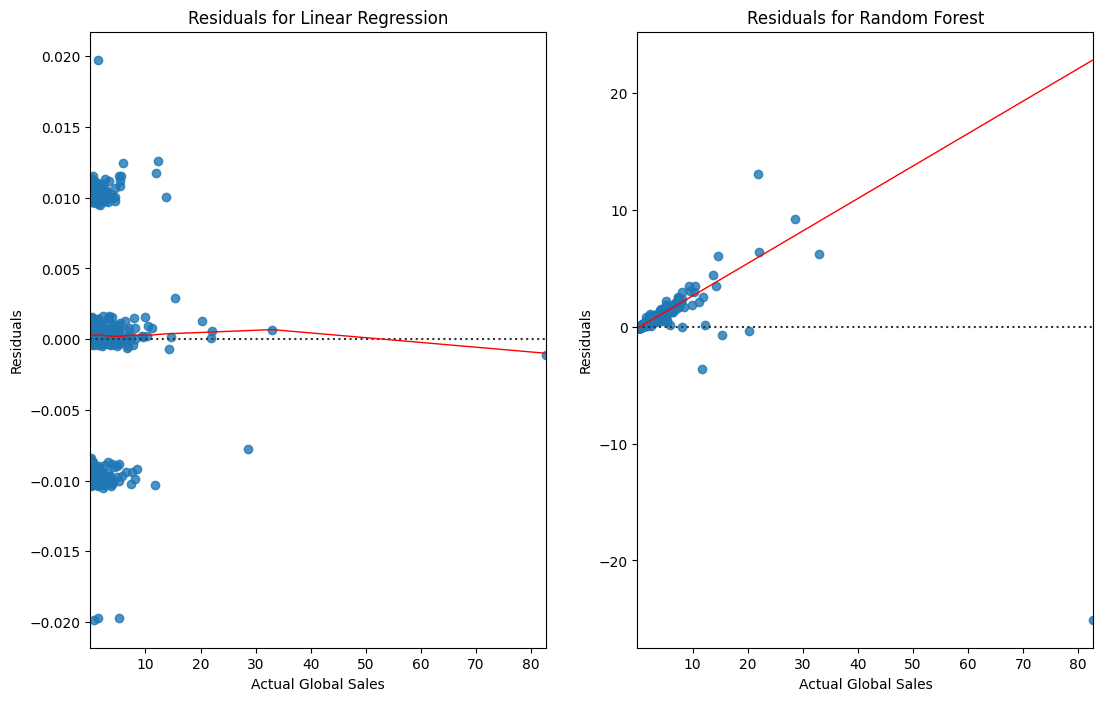

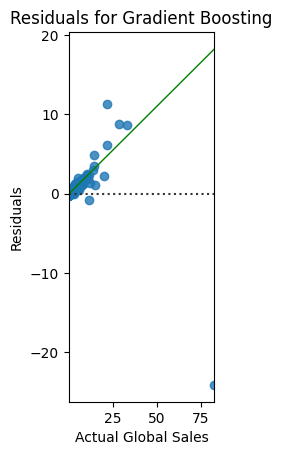

In [25]:
plt.figure(figsize=(20, 6))

# Subplot for Linear Regression residuals
plt.subplot(1, 3, 1)
sns.residplot(x=y_test, y=linear_predictions, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.title('Residuals for Linear Regression')
plt.xlabel('Actual Global Sales')
plt.ylabel('Residuals')

# Subplot for Random Forest residuals
plt.subplot(1, 3, 2)
sns.residplot(x=y_test, y=forest_predictions, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.title('Residuals for Random Forest')
plt.xlabel('Actual Global Sales')
plt.ylabel('Residuals')

# Subplot for Gradient Boosting residuals
plt.subplot(1, 3, 3)
sns.residplot(x=y_test, y=boosting_predictions, lowess=True, line_kws={'color': 'green', 'lw': 1})
plt.title('Residuals for Gradient Boosting')
plt.xlabel('Actual Global Sales')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

In [ ]:
# Plotting Test MSE vs. Training MSE
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training MSE')
plt.plot(history.history['val_loss'], label='Testing MSE')
plt.title('Testing MSE vs. Training MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()